In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score

from clean_data import clean_data
from preprocess_fit import preprocess_fit

# magic word for producing visualizations in notebook
%matplotlib inline

In [9]:
# Load feature info
feat_info = pd.read_csv('features.csv')
feat_info.set_index('attribute', inplace=True)

# Parse missing_or_known string into a list
def parse_missing(s):
    a = s[1:-1].split(',')
    return a

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)

In [10]:
# impute, scale, and PCA
def preprocess_transform(df_clean, imputer, scaler, pca):
    df_inputed = imputer.transform(df_clean)
    df_scaled = scaler.transform(df_inputed) 
    df_pca = pca.transform(df_scaled)
    return df_pca

In [11]:
# Load and clean population data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
azdias_clean, azdias_dropped = clean_data(azdias, feat_info, row_threshold=10)

# Preprocess and fit population data
azdias_pca, imputer, scaler, pca = preprocess_fit(azdias_clean, pca_n=76, impute_strat='median')

In [4]:
# Cluster population data and predict labels 
k = 6
kmeans = KMeans(n_clusters=k)
clust_model = kmeans.fit(azdias_pca)
population_labels = clust_model.predict(azdias_pca)

In [6]:
# Load in the customer demographics data.
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean, customers_dropped = clean_data(customers, feat_info, row_threshold=10)
customers_pca = preprocess_transform(customers_clean, imputer, scaler, pca)
customers_labels = clust_model.predict(customers_pca)

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


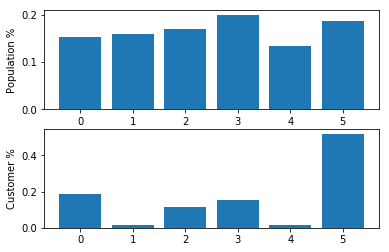

In [7]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

pop = pd.Series(population_labels)
cust = pd.Series(customers_labels)

plt.subplot(2, 1, 1)
ax1 = plt.bar(pop.value_counts().index, pop.value_counts() / pop.value_counts().sum())
plt.ylabel('Population %')

plt.subplot(2, 1, 2)
ax2 = plt.bar(cust.value_counts().index, cust.value_counts() / cust.value_counts().sum())
plt.ylabel('Customer %')

plt.show()

## Part 2: Supervised Learning Model

In [6]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [12]:
y = mailout_train.RESPONSE
X = mailout_train.drop('RESPONSE', axis=1)

X_clean, X_dropped = clean_data(X, feat_info, row_threshold=len(mailout_train.columns))
X_pca = preprocess_transform(X_clean, imputer, scaler, pca)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
y_train.value_counts()

0    33943
1      426
Name: RESPONSE, dtype: int64

### Try applying clustering

In [15]:
X_train_labels = clust_model.predict(X_train)

In [16]:
print(X_train.shape)
print(len(X_train_labels))
X_combined = pd.DataFrame({'RESPONSE':y_train, 'Cluster':X_train_labels})
X_combined.head()

(34369, 76)
34369


,RESPONSE,Cluster
25923,0,5
14938,0,0
1928,0,5
20513,0,3
2325,0,5


In [17]:
p_yes = X_combined[X_combined.RESPONSE == 1].Cluster.value_counts() / X_combined[X_combined.RESPONSE == 1].Cluster.value_counts().sum()
print(p_yes)
p_no = X_combined[X_combined.RESPONSE == 0].Cluster.value_counts() / X_combined[X_combined.RESPONSE == 0].Cluster.value_counts().sum()
print(p_no)

5    0.413146
3    0.190141
1    0.161972
2    0.119718
0    0.107981
4    0.007042
Name: Cluster, dtype: float64
5    0.362137
3    0.210883
1    0.174734
0    0.136258
2    0.105441
4    0.010547
Name: Cluster, dtype: float64


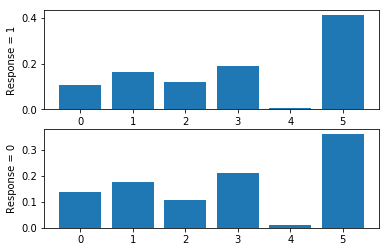

In [18]:
plt.subplot(2, 1, 1)
ax1 = plt.bar(p_yes.index, p_yes)
plt.ylabel('Response = 1')

plt.subplot(2, 1, 2)
ax1 = plt.bar(p_no.index, p_no)
plt.ylabel('Response = 0')

plt.show()

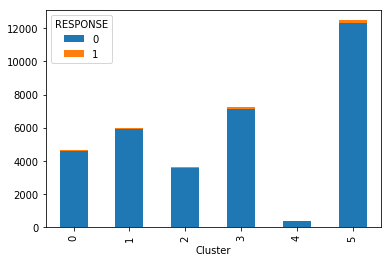

In [23]:
counts = X_combined.groupby('RESPONSE').Cluster.value_counts().unstack(0)
counts.plot.bar(stacked=True);

### AdaBoost

In [66]:
ada = AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'), algorithm='SAMME.R')
ada.fit(X_train, y_train)

In [14]:
y_preds = ada.predict(X_test)
print(classification_report(y_test, y_preds))
print(roc_auc_score(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8487
           1       0.02      0.08      0.03       106

   micro avg       0.95      0.95      0.95      8593
   macro avg       0.50      0.52      0.50      8593
weighted avg       0.98      0.95      0.96      8593

0.5158788913565919


In [63]:
# Dealing with the class imbalance
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_resampled, y_resampled = cc.fit_sample(X_train, y_train)

In [64]:
pd.value_counts(y_resampled)

1    426
0    426
dtype: int64

In [67]:
ada.fit(X_resampled, y_resampled)
y_preds = ada.predict(X_test)
roc_auc_score(y_test, y_preds)

0.503457007498705

In [39]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__class_weight': 'balanced',
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight='balanced', criterion='gini',
             max_depth=None, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 

In [69]:
# Improving the model
parameters = {
    'base_estimator__class_weight':['balanced', None],
    'base_estimator__max_depth':[50, 100, None],
    'n_estimators':[50, 100],
    'learning_rate':[.75, 1]
}

cv = GridSearchCV(ada, parameters, cv=3, scoring='roc_auc')
cv.fit(X_resampled, y_resampled)
print(cv.best_params_)

{'base_estimator__class_weight': None, 'base_estimator__max_depth': 100, 'learning_rate': 1, 'n_estimators': 50}


In [70]:
y_preds = cv.predict(X_test)
roc_auc_score(y_test, y_preds)

0.5128320561302414

### Keras

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization

Using TensorFlow backend.


In [71]:
X_train.shape[1]

76

In [57]:
def make_model(n_features):
    model = Sequential()
    model.add(Dense(50, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [60]:
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import ClusterCentroids, NearMiss

def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
    model = make_model(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train, y_train,
                                                random_state=42)
    model.fit_generator(generator=training_generator, epochs=50, verbose=1)
    y_pred = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_pred)

In [61]:
roc_auc = fit_predict_balanced_model(X_train, y_train, X_test, y_test)
roc_auc

Epoch 1/50
26/26 [==============================] - 1s 52ms/step - loss: 0.8552 - acc: 0.4940
Epoch 2/50
26/26 [==============================] - 0s 9ms/step - loss: 0.7566 - acc: 0.5300
Epoch 3/50
26/26 [==============================] - 0s 8ms/step - loss: 0.6989 - acc: 0.5721
Epoch 4/50
26/26 [==============================] - 0s 9ms/step - loss: 0.6518 - acc: 0.6238
Epoch 5/50
26/26 [==============================] - 0s 9ms/step - loss: 0.6355 - acc: 0.6334
Epoch 6/50
26/26 [==============================] - 0s 8ms/step - loss: 0.6271 - acc: 0.6430
Epoch 7/50
26/26 [==============================] - 0s 9ms/step - loss: 0.5897 - acc: 0.6659
Epoch 8/50
26/26 [==============================] - 0s 9ms/step - loss: 0.5742 - acc: 0.6923
Epoch 9/50
26/26 [==============================] - 0s 9ms/step - loss: 0.5615 - acc: 0.6851
Epoch 10/50
26/26 [==============================] - 0s 9ms/step - loss: 0.5453 - acc: 0.7091
Epoch 11/50
26/26 [==============================] - 0s 9ms/step - l

0.5072030252706137